In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
# Enable inline plotting  
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
cores_per_node = {
                  '1': [1, 4, 8, 16, 28],
                  '2': [28, 42, 56],
                  '4': [84, 98, 112],
                  '6': [140, 154, 168],
                  '8': [196, 210, 224],
                  '12': [308, 322, 336],
                  '16': [420, 434, 448]
                  }

repeats = 3

In [3]:
def reduce_to_means(N, n):
    """Helper function to reduce data from numpy arrays.
    
    First it takes the mean across all ranks for each timing,
    then it takes the mean and standard deviation across the repeats.
    
    Parameters
    ----------
    n : int
        number of processes used in run
        
    Returns
    -------
    means : list
        mean across number of repeats for each timing
    stds : list
        standard deviation across repeats for each timing
        
    """
    
    init_total = np.empty(3)
    init_top = np.empty_like(init_total)
    init_traj = np.empty_like(init_total)
    open_traj = np.empty_like(init_total)
    n_atoms = np.empty_like(init_total)
    set_units = np.empty_like(init_total)
    io = np.empty_like(init_total)
    io_per_frame = np.empty_like(init_total)
    copy_data = np.empty_like(init_total)
    copy_box = np.empty_like(init_total)
    get_dataset = np.empty_like(init_total)
    set_ts_position = np.empty_like(init_total)
    convert_units = np.empty_like(init_total)
    rmsd = np.empty_like(init_total)
    rmsd_per_frame = np.empty_like(init_total)
    wait = np.empty_like(init_total)
    comm_gather = np.empty_like(init_total)
    total = np.empty_like(init_total)

    _dict = {f'a{i}': np.load(f'{N}node_{i}/{n}process_times.npy') for i in range(1, repeats+1)}

    for i, array in enumerate(_dict.values()):
        init_total[i] = np.mean(array[:, 1])
        init_top[i] = np.mean(array[:, 2])
        init_traj[i] = np.mean(array[:, 3])
        open_traj[i] = np.mean(array[:, 4])
        n_atoms[i] = np.mean(array[:, 5])
        set_units[i] = np.mean(array[:, 6])
        io[i] = np.mean(array[:, 7])
        io_per_frame[i] = np.mean(array[:, 8])
        copy_data[i] = np.mean(array[:, 9])
        copy_box[i] = np.mean(array[:, 10])
        get_dataset[i] = np.mean(array[:, 11])
        set_ts_position[i] = np.mean(array[:, 12])
        convert_units[i] = np.mean(array[:, 13])
        rmsd[i] = np.mean(array[:, 14])
        rmsd_per_frame[i] = np.mean(array[:, 15])
        wait[i] = np.mean(array[:, 16])
        comm_gather[i] = np.mean(array[:, 17])
        total[i] = np.mean(array[:, 18])

    means = [n, np.mean(init_total), np.mean(init_top), np.mean(init_traj), np.mean(open_traj), 
             np.mean(n_atoms), np.mean(set_units), np.mean(io), np.mean(io_per_frame),
             np.mean(copy_data), np.mean(copy_box), np.mean(get_dataset), np.mean(set_ts_position), np.mean(convert_units),
             np.mean(rmsd), np.mean(rmsd_per_frame), np.mean(wait), np.mean(comm_gather), np.mean(total)]
    stds = [n, np.std(init_total), np.std(init_top), np.std(init_traj), np.std(open_traj), 
             np.std(n_atoms), np.std(set_units), np.std(io), np.std(io_per_frame),
             np.std(copy_data), np.std(copy_box), np.std(get_dataset), np.std(set_ts_position), np.std(convert_units),
             np.std(rmsd), np.std(rmsd_per_frame), np.std(wait), np.std(comm_gather), np.std(total)]

    return means, stds

In [4]:
def get_raw_data(N, n, averaged=False):
    """Gets the raw data from all repeats and displays in a pandas DataFrame.
    
    If averaged=True, it takes the average and standard deviation across all 
    repeats for all (rank x timing) elements.
    
    Parameters
    ----------
    n : int
        number of processes used in run
    averaged: bool (optional)
    
    Returns
    -------
    all data (if averaged=False) : pd.DataFrame
        pandas dataframe of raw data arrays stacked horizontally with no reductions
    means (if averaged=True) : pd.DataFrame
        mean across repeats for each (rank x timing) element
    stds (if averaged=True) : pd.DataFrame 
        standard deviation across repeats for each (rank x timing) element
    
    """
    
    
    columns = ['rank', 'init_total', 'init_topology', 'init_trajectory', 
               'open_traj', 'n_atoms', 'set_units', 'io', 'io/frame',
               'copy_data', 'copy_box', 'get_dataset', 'set_ts_position', 'convert_units',
               'rmsd_compute', 'rmsd_compute/frame', 'wait', 'comm_gather',
               'total bench']
    
    _dict = {f'a{i}': np.load(f'{N}node_{i}/{n}process_times.npy') for i in range(1, repeats+1)}
    
    if averaged:
        means_buffer = np.zeros(shape=(n,19), dtype=float)
        stds_buffer = np.zeros(shape=(n,19), dtype=float)
        
        # fills in means and std arrays 1 element at a time
        for i in range(n):
            for j in range(19):
                temp_array = np.empty(repeats, dtype=float) 
                for trial, k in enumerate(range(len(temp_array)), 1):
                    temp_array[k] = _dict[f'a{trial}'][i, j]
                means_buffer[i, j] = np.mean(temp_array)
                stds_buffer[i, j] = np.std(temp_array)
                
        return pd.DataFrame(list(means_buffer), columns=columns).set_index('rank'), pd.DataFrame(list(stds_buffer), columns=columns).set_index('rank')
    
    else:
        arrays = tuple(_dict.values())
        a = np.hstack(arrays)
        
        return pd.DataFrame(list(a), columns=repeats*columns)

In [5]:
def all_process_dataframe():
    """Gives DataFrame of averaged timings for all N_process runs.
    
    Returns
    -------
    times_dframe : pd.DataFrame
        benchmark times with timings first averaged across all ranks, then averaged across repeats
    stds_dframe : pd.DataFrame 
        standard deviation of the timings when averaged across repeats   
    
    """
    columns = ['N_Processes', 'Total_Initialize', 'Initialize_Topology', 
                'Initialize_Trajectory', 'Open_Trajectory', 'Set_n_atoms',
                'Set_Units', 'IO', 'IO/Frame', 'Copy_Data', 'Copy_Box',
                'Get_Dataset', 'Set_ts_Position', 'Convert_Units',
                'RMSD', 'RMSD/Frame', 'Wait', 'Comm_Gather', 'Total_Benchmark_Time']
    
    data_buffer = np.empty(shape=(23,19), dtype=float)
    stds_buffer = np.empty(shape=(23,19), dtype=float)
    
    count = -1
    for N in [1,2,4,6,8,12,16]:
        if N == 16:
            repeats = 2
            for i, cores in enumerate(cores_per_node[f'{N}'], count+1):
                count = i
                means, stds = reduce_to_means(N, cores)
                for j in range(19):
                    data_buffer[i, j] = means[j]
                    stds_buffer[i, j] = stds[j]

    times_dframe = pd.DataFrame(list(data_buffer), columns=columns).set_index('N_Processes')
    stds_dframe = pd.DataFrame(list(stds_buffer), columns=columns).set_index('N_Processes')
            
    return times_dframe, stds_dframe

In [6]:
def plot_line_graph(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_io_stds = stds_dataframe.IO.to_numpy()
            t_rmsd_stds = stds_dataframe.RMSD.to_numpy()
            t_init_total_stds = stds_dataframe.Total_Initialize.to_numpy()
            t_init_top_stds = stds_dataframe.Initialize_Topology.to_numpy()
            t_init_traj_stds = stds_dataframe.Initialize_Trajectory.to_numpy()
            t_wait_stds = stds_dataframe.Wait.to_numpy()
            t_comm_stds = stds_dataframe.Comm_Gather.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_io_stds, t_rmsd_stds, t_init_top_stds, t_init_traj_stds, t_wait_stds, t_comm_stds]
        timing_dataframe.loc[:, ['IO','RMSD','Initialize_Topology',
                      'Initialize_Trajectory','Wait','Comm_Gather']].plot(color=['blue',
                                                                            'orange', 
                                                                            'black',
                                                                            'green',
                                                                            'purple',
                                                                            'red'], yerr=yerrs, ax=axes, marker='o')
        lgd = plt.legend(['IO', 'RMSD','Initialize Topology', 
                              'Initialize Trajectory','Wait', 'Communication'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 460)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [7]:
def plot_init_breakdown_line(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_init_traj_stds = stds_dataframe.Initialize_Trajectory.to_numpy()
            t_open_traj_stds = stds_dataframe.Open_Trajectory.to_numpy()
            t_n_atoms_stds = stds_dataframe.Set_n_atoms.to_numpy()
            t_set_units_stds = stds_dataframe.Set_Units.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_init_traj_stds, t_open_traj_stds, t_n_atoms_stds, t_set_units_stds]
        timing_dataframe.loc[:, ['Initialize_Trajectory','Open_Trajectory','Set_n_atoms','Set_Units']].plot(color=['green',
                                                                                                        'blue', 
                                                                                                        'black',
                                                                                                        'red'], 
                                                                                                  yerr=yerrs, 
                                                                                                  ax=axes, 
                                                                                                  marker='o')
        lgd = plt.legend(['Initialize Trajectory', 'Open File','Set n_atoms','Set Units'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 460)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [8]:
def plot_io_breakdown_line(timing_dataframe, stds_dataframe=None):
        
        if stds_dataframe is not None:
            t_io_stds = stds_dataframe.IO.to_numpy()
            t_data_stds = stds_dataframe.Copy_Data.to_numpy()
            t_get_pos_stds = stds_dataframe.Get_Dataset.to_numpy()
            t_set_pos_stds = stds_dataframe.Set_ts_Position.to_numpy()
            t_box_stds = stds_dataframe.Copy_Box.to_numpy()
            t_convert_units_stds = stds_dataframe.Convert_Units.to_numpy()

        plt.rcParams['font.size'] = 9
        sns.set_style('ticks')
        fig = plt.figure(figsize=(10,10))
        axes = fig.add_subplot(1,1,1)
        yerrs = [t_io_stds, t_data_stds, t_get_pos_stds, t_set_pos_stds, t_box_stds, t_convert_units_stds]
        timing_dataframe.loc[:, ['IO','Copy_Data','Get_Dataset','Set_ts_Position','Copy_Box','Convert_Units']].plot(color=['black',
                                                                                                        'orange', 
                                                                                                        'blue',
                                                                                                        'purple',
                                                                                                        'green',
                                                                                                        'red'], 
                                                                                                  yerr=yerrs, 
                                                                                                  ax=axes, 
                                                                                                  marker='o')
        lgd = plt.legend(['Total IO','Fill Data', 'Get Dataset','Set Position ts', 
                              'Fill Box','Convert Units'],
                             loc='upper center', bbox_to_anchor=(0.5, -0.2),
                             frameon=False, shadow=False, ncol=2, prop={'size':12})
        axes.set_xlabel('$N_{Processes}$', fontsize=18)
        axes.set_ylabel('Time (s)', fontsize=18)
        #axes.set_title('900 Frame Trajectory on 12-core Local Workstation', fontsize=24)
        plt.xscale('log')
        plt.yscale('log')
        #axes.set_ylim(0,10000)
        axes.set_xlim(1, 460)
        axes.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
        axes.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        axes.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.4)

In [9]:
def plot_io_scaling(timing_dataframe, stds_dataframe=None, init_subtracted=False):
        
    n_proc = timing_dataframe.index.to_numpy()
    t_io = timing_dataframe.IO.to_numpy()
    t_data = timing_dataframe.Copy_Data.to_numpy()
    t_box = timing_dataframe.Copy_Box.to_numpy()
    t_get_pos = timing_dataframe.Get_Dataset.to_numpy()
    t_set_pos = timing_dataframe.Set_ts_Position.to_numpy()

    speedup_io = [t_io[0]/t_io[i] for i in range(len(t_io))]
    efficiency_io = [speedup_io[i]/n_proc[i] for i in range(len(t_io))]
    
    speedup_data = [t_data[0]/t_data[i] for i in range(len(t_data))]
    efficiency_data = [speedup_data[i]/n_proc[i] for i in range(len(t_data))]
    
    speedup_box = [t_box[0]/t_box[i] for i in range(len(t_box))]
    efficiency_box = [speedup_box[i]/n_proc[i] for i in range(len(t_box))]
    
    speedup_get_pos = [t_get_pos[0]/t_get_pos[i] for i in range(len(t_get_pos))]
    efficiency_get_pos = [speedup_get_pos[i]/n_proc[i] for i in range(len(t_get_pos))]
    
    speedup_set_pos = [t_set_pos[0]/t_set_pos[i] for i in range(len(t_set_pos))]
    efficiency_set_pos = [speedup_set_pos[i]/n_proc[i] for i in range(len(t_set_pos))]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    plt.style.use('ggplot')
    sns.set_style('ticks')

    ax1.plot(n_proc, n_proc, 'k--', linewidth='3.5')
    ax1.plot(n_proc, speedup_io, marker='.', color='black', label='Total IO', linewidth='3')
    ax1.plot(n_proc, speedup_data, marker='.', color='orange', label='Copy Data', linewidth='3')
    ax1.plot(n_proc, speedup_box, marker='.', color='blue', label='Fill Box', linewidth='3')
    ax1.plot(n_proc, speedup_get_pos, marker='.', color='red', label='Get Position Dataset', linewidth='3')
    ax1.plot(n_proc, speedup_set_pos, marker='.', color='purple', label='Set Position ts', linewidth='3')
    ax1.set(xlim=[1,448], ylim=[1,448], title='Speedup', ylabel='Speedup')
    ax1.set_title('Speedup', fontsize=24)
    ax1.set_xlabel('$N_{Processes}$', fontsize=24)
    ax1.set_ylabel('$S(N) = t_1/t_N$', fontsize=24)
    ax1.legend(fontsize=20)
    ax1.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    
    ax2.plot(n_proc, efficiency_io, marker='.', color='black', label='Total IO', linewidth='3')
    ax2.plot(n_proc, efficiency_data, marker='.', color='orange', label='Copy Data',  linewidth='3')
    ax2.plot(n_proc, efficiency_box, marker='.', color='blue', label='Fill Box', linewidth='3')
    ax2.plot(n_proc, efficiency_get_pos, marker='.', color='red', label='Get Position Dataset', linewidth='3')
    ax2.plot(n_proc, efficiency_set_pos, marker='.', color='purple', label='Set Position ts', linewidth='3')
    ax2.set(xlim=[1,448], ylim=[0,1.2])
    ax2.set_title('Efficiency', fontsize=24)
    ax2.set_xlabel('$N_{Processes}$', fontsize=24)
    ax2.set_ylabel('E(N) = S(N)/N', fontsize=24)
    ax2.legend(fontsize=20)
    ax2.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')

In [10]:
def plot_scaling(timing_dataframe, stds_dataframe=None, full_nodes=False, init_subtracted=False):
        
    n_proc = timing_dataframe.index.to_numpy()
    t_io = timing_dataframe.IO.to_numpy()
    t_init = timing_dataframe.Total_Initialize.to_numpy()
    t_rmsd = timing_dataframe.RMSD.to_numpy()
    t_total = timing_dataframe.Total_Benchmark_Time.to_numpy()
    
    if full_nodes:
        n_proc = n_proc[[0, 4, 7, 10, 13, 16, 19, 22]]
        t_io = t_io[[0, 4, 7, 10, 13, 16, 19, 22]]
        t_init = t_init[[0, 4, 7, 10, 13, 16, 19, 22]]
        t_rmsd = t_rmsd[[0, 4, 7, 10, 13, 16, 19, 22]]
        t_total = t_total[[0, 4, 7, 10, 13, 16, 19, 22]]
    
    if init_subtracted:
        t_total = t_total - t_init
        
    speedup_rmsd = [t_rmsd[0]/t_rmsd[i] for i in range(len(t_rmsd))]
    efficiency_rmsd = [speedup_rmsd[i]/n_proc[i] for i in range(len(t_rmsd))]
    speedup_io = [t_io[0]/t_io[i] for i in range(len(t_io))]
    efficiency_io = [speedup_io[i]/n_proc[i] for i in range(len(t_io))]
    speedup_total = [t_total[0]/t_total[i] for i in range(len(t_total))]
    efficiency_total = [speedup_total[i]/n_proc[i] for i in range(len(t_total))]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    plt.style.use('ggplot')
    sns.set_style('ticks')

    ax1.plot(n_proc, n_proc, 'k--', linewidth='3.5')
    ax1.plot(n_proc, speedup_rmsd, marker='o', color='orange', label='RMSD', linewidth='3')
    ax1.plot(n_proc, speedup_io, marker='o', color='blue', label='IO', linewidth='3')
    ax1.plot(n_proc, speedup_total, linestyle='--', marker='o', color='red', label='Total', linewidth='3')
    ax1.set(xlim=[1,448], ylim=[1,448], title='Speedup')
    ax1.set_title('Speedup', fontsize=24)
    ax1.set_xlabel('$N_{Processes}$', fontsize=24)
    ax1.set_ylabel('$S(N) = t_1/t_N$', fontsize=24)
    ax1.legend(fontsize=20)
    ax1.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax1.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax1.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    
    ax2.plot(n_proc, efficiency_rmsd, marker='o', color='orange', label='RMSD',  linewidth='3')
    ax2.plot(n_proc, efficiency_io, marker='o', color='blue', label='IO', linewidth='3')
    ax2.plot(n_proc, efficiency_total, marker='o', color='red', label='Total', linewidth='3')
    ax2.set(xlim=[1,448], ylim=[0,1.6])
    ax2.set_title('Efficiency', fontsize=24)
    ax2.set_xlabel('$N_{Processes}$', fontsize=24)
    ax2.set_ylabel('E(N) = S(N)/N', fontsize=24)
    ax2.legend(fontsize=20)
    ax2.yaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='major', linewidth='0.5', linestyle='--', color='grey')
    ax2.yaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')
    ax2.xaxis.grid(which='minor', linewidth='0.5', linestyle='--', color='grey')

In [11]:
means,stds = all_process_dataframe()
means

,Total_Initialize,Initialize_Topology,Initialize_Trajectory,Open_Trajectory,Set_n_atoms,Set_Units,IO,IO/Frame,Copy_Data,Copy_Box,Get_Dataset,Set_ts_Position,Convert_Units,RMSD,RMSD/Frame,Wait,Comm_Gather,Total_Benchmark_Time
N_Processes,,,,,,,,,,,,,,,,,,
1.0,2.102943,0.404043,1.698467,0.238246,1.263880,0.001880,4388.951230,0.048712,132.060846,116.859578,4044.947003,0.939630,19.030770,16.648309,0.000185,0.000020,0.000448,4407.702950
4.0,1.314587,0.724946,0.589190,0.276989,0.176644,0.001855,813.828146,0.036130,30.282159,23.351952,738.091719,0.226078,4.416329,3.806281,0.000169,164.262053,0.000369,983.211436
8.0,2.176538,1.621471,0.554582,0.413383,0.039697,0.002763,300.175937,0.026653,13.047376,8.799183,267.977250,0.133129,2.336056,1.823236,0.000162,53.602680,0.000531,357.778922
16.0,2.847225,1.935742,0.911045,0.755290,0.030735,0.001508,147.743259,0.026236,6.703127,4.630941,130.752428,0.084182,1.327650,0.931779,0.000165,16.394431,0.000350,167.917044
28.0,5.628972,3.816327,1.812210,1.738474,0.034316,0.001452,92.600040,0.028777,4.677073,4.420756,79.947881,0.051689,0.804316,0.542438,0.000169,18.312709,0.000365,117.084524
28.0,5.269674,3.305607,1.963512,1.242816,0.360126,0.002103,221.876160,0.068951,7.772535,7.785789,200.479052,0.055822,0.927549,0.659082,0.000205,27.127731,0.000659,254.933305
42.0,10.634395,2.948064,7.685805,7.358433,0.066660,0.002001,84.964785,0.039606,3.992792,4.731834,72.791745,0.034588,0.556160,0.379061,0.000177,8.810474,0.000451,104.789167
56.0,4.207486,1.590239,2.616704,2.467756,0.063737,0.001432,62.047655,0.038565,3.252665,3.590360,52.768964,0.026801,0.426977,0.287381,0.000179,3.406476,0.000453,69.949451
84.0,4.869793,1.149001,3.720198,3.371064,0.186752,0.001738,71.977668,0.067101,3.750108,4.033492,61.992084,0.018950,0.312712,0.215248,0.000201,15.344133,0.000781,92.407623


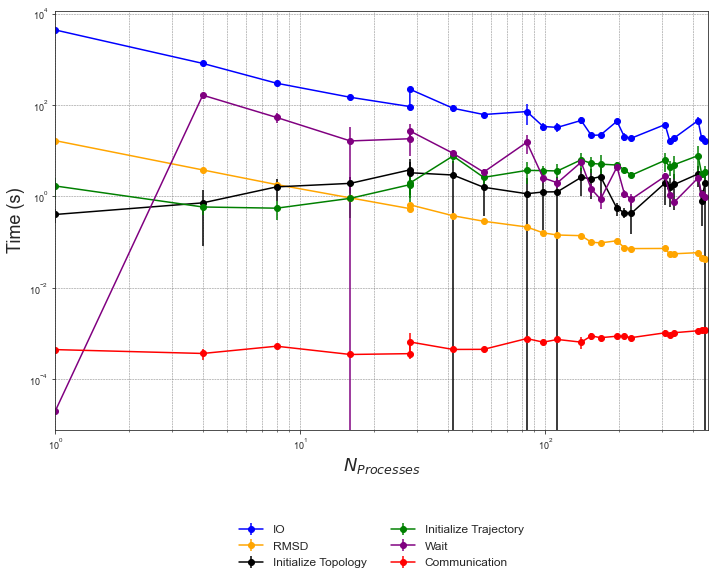

In [12]:
plot_line_graph(means, stds)

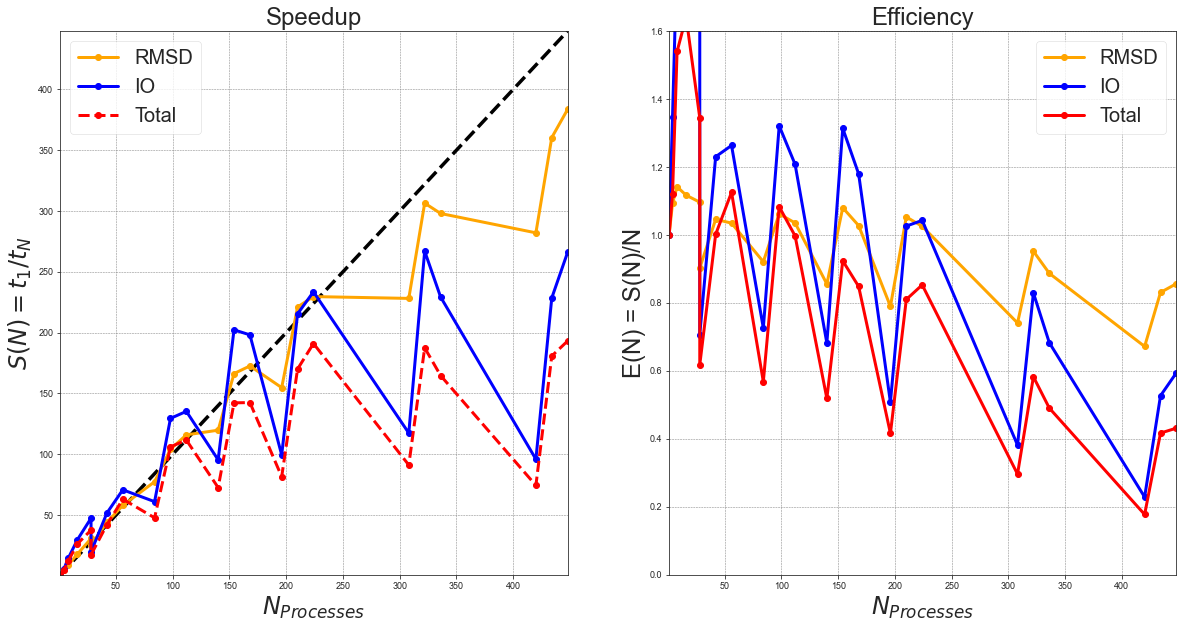

In [13]:
plot_scaling(means, stds, init_subtracted=False)

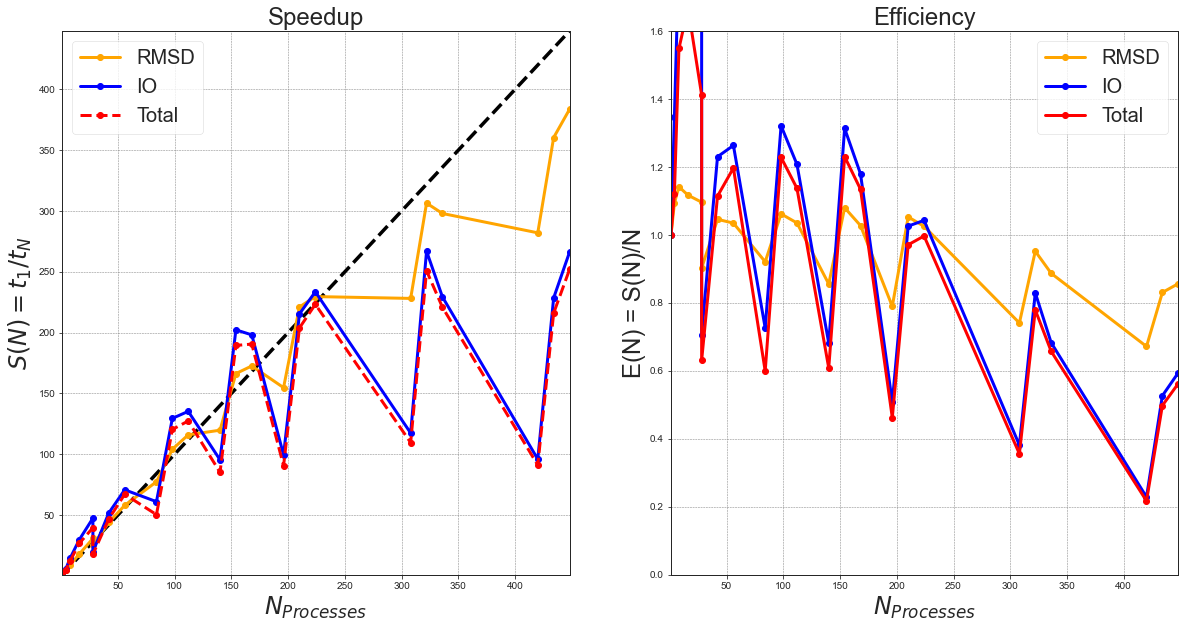

In [14]:
plot_scaling(means, stds, init_subtracted=True)

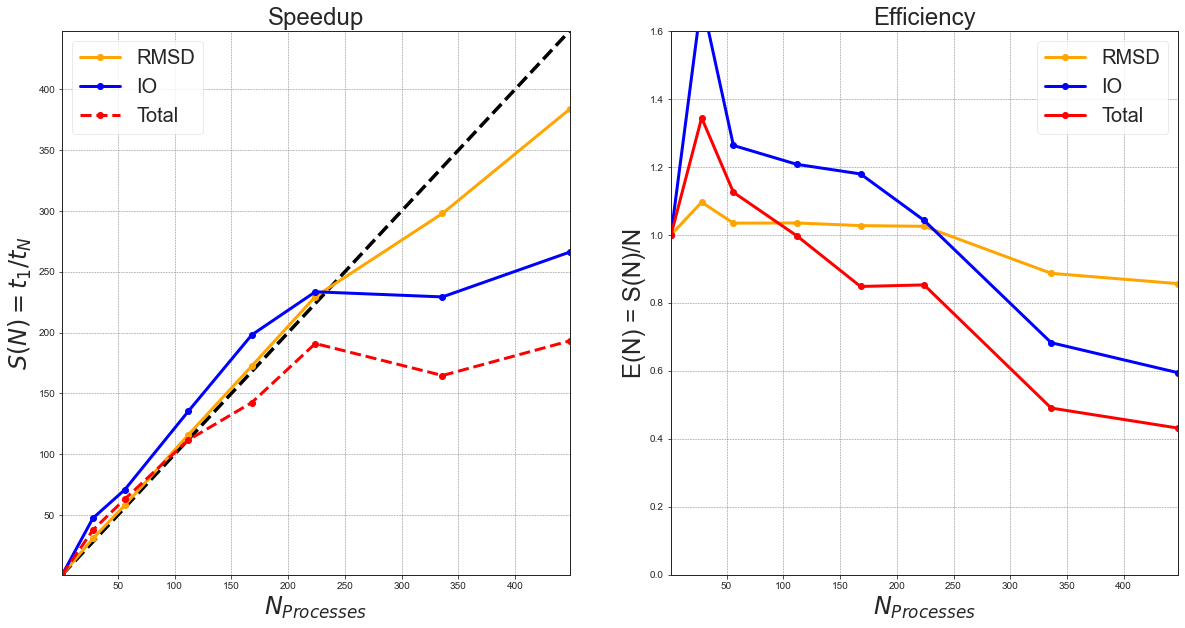

In [15]:
plot_scaling(means,stds, full_nodes=True)

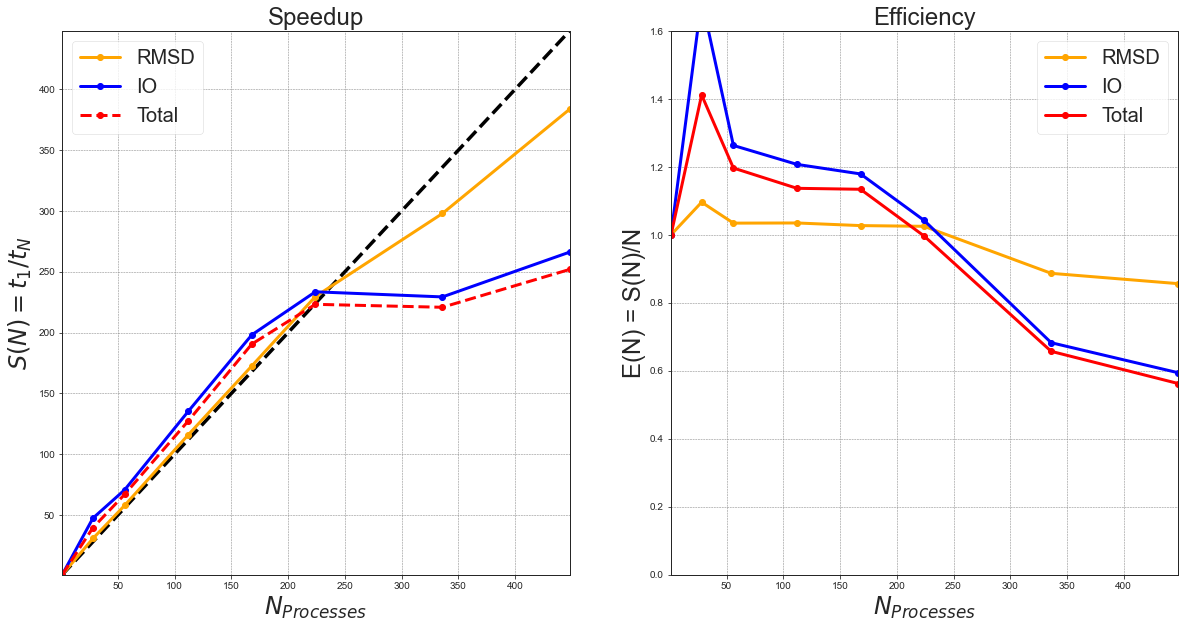

In [16]:
plot_scaling(means,stds, full_nodes=True, init_subtracted=True)

In [17]:
full = means.index.to_numpy()
full

array([  1.,   4.,   8.,  16.,  28.,  28.,  42.,  56.,  84.,  98., 112.,
       140., 154., 168., 196., 210., 224., 308., 322., 336., 420., 434.,
       448.])

In [19]:
full[[0, 4, 7, 10, 13, 16, 19, 22]]

array([  1.,  28.,  56., 112., 168., 224., 336., 448.])